# Modeling

### goals
* develop a model that effectively predicts 2019 AQI pollution levels
* fit model with training dataset
* try grid search (b/c we have a small dataset (maybe experiemnt with random grid))


In [263]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn import preprocessing, svm
from sklearn.metrics import r2_score, accuracy_score

#Use to ignore convergence warnings
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)


# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
# np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

In [198]:
# import X and y training and test sets
# 75/25 train-test split

X = pd.read_csv('../../data/train_test/X_alt')

X_train = pd.read_csv('../../data/train_test/X_train_scaled_alt')

X_test = pd.read_csv('../../data/train_test/X_test_scaled_alt')

y = pd.read_csv('../../data/train_test/y_alt')

y_train = pd.read_csv('../../data/train_test/y_train_alt')

y_test = pd.read_csv('../../data/train_test/y_test_alt')


# Form a baseline for comparison


In [206]:
# with mean
dummy = DummyRegressor(strategy='mean')

dummy.fit(X_train, y_train)
dummy.predict(X_test)

dummy.score(X_test, y_test)


-0.014729087673823082

In [207]:
# with median
dummy = DummyRegressor(strategy='median')

dummy.fit(X_train, y_train)
dummy.predict(X_test)

dummy.score(X_test, y_test)


-0.006734833218899672

In [208]:
# used to test feature selection
select_k_best = SelectKBest(f_regression, k=25)
X_train_k_best = select_k_best.fit_transform(X_train, y_train)

best_k_cols = X_train.columns[select_k_best.get_support()]
best_k_cols

Index(['HAA_MALE_ratio_2017_2019_diff', 'HAAC_MALE_ratio_2017_2019_diff',
       'HAA_MALE_ratio_2018_2019_diff', 'NH_FEMALE_ratio_2017_2018_pct_change',
       'H_FEMALE_ratio_2017_2018_pct_change',
       'TOT_FEMALE_ratio_2017_2019_pct_change',
       'NH_FEMALE_ratio_2017_2019_pct_change',
       'Personal income (thousands of dollars) 2018_2019_pct_change',
       'NH_FEMALE_ratio_2018_2019_pct_change', 'Unemployment_rate_2018',
       'LESS_HS_TOT_ratio_2018', 'NH_MALE_ratio_2018', 'NH_FEMALE_ratio_2018',
       'H_MALE_ratio_2018', 'H_FEMALE_ratio_2018', 'HWA_MALE_ratio_2018',
       'HWA_FEMALE_ratio_2018', 'HIA_MALE_ratio_2018', 'HIA_FEMALE_ratio_2018',
       'HAA_MALE_ratio_2018', 'HAA_FEMALE_ratio_2018', 'HWAC_MALE_ratio_2018',
       'HWAC_FEMALE_ratio_2018', 'HIAC_MALE_ratio_2018',
       'HIAC_FEMALE_ratio_2018'],
      dtype='object')

In [233]:
param_grid = {'alpha':np.arange(0.19, .3, step=0.001),
              'selection':['random', 'cyclic'],
              'positive':[True, False],
              'fit_intercept':[True,False], 'random_state':[42],
              'normalize':[True,False], 'warm_start':[True,False]}
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, param_grid, cv=5)
lasso_grid.fit(X_train_k_best, y_train)
print('best score: ', lasso_grid.best_score_, 'best params', lasso_grid.best_params_)
print('best estimator', lasso_grid.best_estimator_)

best score:  0.1926943513711381 best params {'alpha': 0.21900000000000003, 'fit_intercept': True, 'normalize': False, 'positive': False, 'random_state': 42, 'selection': 'cyclic', 'warm_start': True}
best estimator Lasso(alpha=0.21900000000000003, random_state=42, warm_start=True)


* With Lasso, it appears not an effective model with best score of .191
* Using 25 best parameters seems sufficient
* best params for this appears to be (alpha=0.2, random_state=42, warm_start=True)


In [234]:
# try scoring this param with reduced features and hyperparameters from above
lasso_best = Lasso(alpha=0.21900000000000003, random_state=42, warm_start=True)
lasso_best.fit(X_train_k_best, y_train)

# this retrieves correlation of determination value
lasso_best.score(X_test[best_k_cols], y_test)

0.4170072322404873

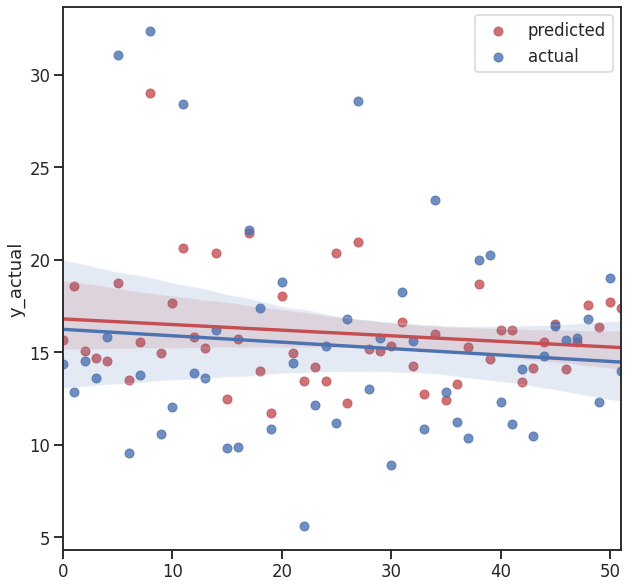

In [232]:
y_pred = lasso_best.predict(X_test[best_k_cols])
lasso_pred_vs_actual = pd.DataFrame({'y_pred':y_pred, 'y_actual':y_test['AQI_2019'].values})
plt.figure(figsize=(10,10))
sns.regplot(x=lasso_pred_vs_actual.index, y='y_pred', data=lasso_pred_vs_actual, color='r', label='predicted')
sns.regplot(x=lasso_pred_vs_actual.index, y='y_actual', data=lasso_pred_vs_actual, color='b', label='actual')
plt.legend()

### Evaluation
A R^2 value of .41 means that using this model would be right for less than half the time, which means it is not a great model and other models
should be tried on
* another aspect to note is that our test score was largely greater than our train score; may need to adjust our test/train split, due to having
small number of observations so may need to adjust proportion to 50/50

In [224]:
# OLS model

ols_param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True,False], 'positive':[True,False]}
ols = LinearRegression()
ols_grid = GridSearchCV(ols, ols_param_grid, cv=5)
ols_grid.fit(X_train_k_best, y_train)
print('best score', ols_grid.best_score_, 'best params', ols_grid.best_estimator_)

best score 0.1057837193062799 best params LinearRegression(normalize=True)


In [225]:
ols_best = LinearRegression(normalize=True)
ols_best.fit(X_train_k_best, y_train)
ols_best.score(X_test[best_k_cols], y_test)

-0.16051786212817798

* Will need to reevaluate model parameters and metrics


In [240]:
# ridge
ridge_param_grid = {'alpha':np.arange(0.1, 2, step=0.1), 'fit_intercept':[True,False], 'normalize':[True,False],
                    'random_state':[42], 'solver':['auto','svd','cholesky','sparse_cg','lsqr','sage']}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_param_grid, cv=5)
ridge_grid.fit(X_train_k_best, y_train)
print('best score', ridge_grid.best_score_, 'best params to have', ridge_grid.best_estimator_)

best score 0.18285848685527997 best params to have Ridge(alpha=0.8, normalize=True, random_state=42, solver='lsqr')


/home/wkc/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [ 1.60179339e-01  1.60179339e-01  1.60179339e-01  1.59902377e-01
  1.59663311e-01             nan  2.87460235e-02  2.87460235e-02
  2.87460235e-02  1.66590888e-02  6.45868460e-03             nan
 -1.41091388e+01 -1.41091388e+01 -1.41091388e+01 -1.41136769e+01
 -1.39322849e+01             nan -1.41091388e+01 -1.41091388e+01
 -1.41091388e+01 -1.41136769e+01 -1.39322849e+01             nan
  1.71900029e-01  1.71900029e-01  1.71900029e-01  1.71806332e-01
  1.71498508e-01             nan  6.58342971e-02  6.58342971e-02
  6.58342971e-02  5.85111942e-02  5.84176419e-02             nan
 -1.37152824e+01 -1.37152824e+01 -1.37152824e+01 -1.37203884e+01
 -1.35623069e+01             nan -1.37152824e+01 -1.37152824e+01
 -1.37152824e+01 -1.37203884e+01 -1.35623069e+01             nan
  1.77622884e-01  1.77622884e-01  1.77622884e-01  1.77019941e-01
  1.768356

In [250]:
ridge_best = Ridge(alpha=0.8, normalize=True, random_state=42, solver='lsqr')
ridge_best.fit(X_train_k_best, y_train)
ridge_best.score(X_test[best_k_cols], y_test)

0.44067326807795015

* about the same results as Lasso, especially the situation of having test score being greater than test score


In [254]:
# try elastic net

els_net_param_grid = {'alpha':np.arange(0.1, 2, step=0.1), 'l1_ratio':np.arange(0.1, 2, step=0.1),
              'selection':['random', 'cyclic'],
              'positive':[True, False],
              'fit_intercept':[True,False], 'random_state':[42],
              'normalize':[True,False], 'warm_start':[True,False]}
els_net = ElasticNet()
els_net_grid = GridSearchCV(els_net, els_net_param_grid, cv=5)
els_net_grid.fit(X_train_k_best, y_train)
print('best score', els_net_grid.best_score_, 'best params', els_net_grid.best_estimator_)

best score 0.19227004771894582 best params ElasticNet(alpha=0.30000000000000004, l1_ratio=0.7000000000000001,
           random_state=42, warm_start=True)


/home/wkc/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.11903843 0.11903843 0.11903667 ...        nan        nan        nan]
  warnings.warn(


In [255]:
els_net_best = ElasticNet(alpha=0.30000000000000004, l1_ratio=0.7000000000000001,
           random_state=42, warm_start=True)
els_net_best.fit(X_train_k_best, y_train)
els_net_best.score(X_test[best_k_cols], y_test)

0.42038399685682215

* same results as other linear regression models


In [266]:
rf_param_grid = {'n_estimators':np.arange(10,1000,step=100), 'criterion':['mse','mae'], 'max_features':['auot','sqrt','log2'],
                 'random_state':[42]}
rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5)
rf_grid.fit(X_train_k_best, y_train)

print('best score', rf_grid.best_score_, 'best params', rf_grid.best_estimator_)

/home/wkc/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.14535284 0.23256004
 0.23730452 0.23594587 0.23979253 0.24155188 0.24226218 0.24099527
 0.2401501  0.24036554 0.10699212 0.22812971 0.22980688 0.23280886
 0.23480529 0.23672917 0.23316331 0.23260637 0.23221838 0.23350182
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.19477793 0.24027087
 0.24815182 0.25203882 0.25512645 0.25110902 0.25303747 0.25088858
 0.25134715 0.24976845 0.1793368  0.2571352  0.26036418 0.2573985
 0.25581371 0.25813295 0.25088269 0.25240099 0.25356801 0.25161911]
  warnings.warn(


best score 0.26036418376503667 best params RandomForestRegressor(criterion='mae', max_features='log2', n_estimators=210,
                      random_state=42)


In [267]:
rf_best = RandomForestRegressor(criterion='mae', max_features='log2', n_estimators=210,
                      random_state=42)
rf_best.fit(X_train_k_best, y_train)
rf_best.score(X_test[best_k_cols], y_test)

0.46542234294578533

* Makes sense that Random Forest Regessor does a littlbe bit better than a individual regressor
